In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import sklearn.manifold
import sklearn.preprocessing
from sklearn.gaussian_process import GaussianProcessRegressor
from typing import List, Tuple
from scipy.stats import norm
from sklearn.gaussian_process.kernels import ConstantKernel

seed = 222
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['figure.dpi'] = 80

In [2]:
d = pd.read_csv('dataQ2.csv')
d

,t,d,temp
0,1,0,10.365770
1,3,0,12.623282
2,4,0,12.387322
3,5,0,12.839057
4,6,0,13.953650
...,...,...,...
395,37,19,10.895081
396,39,19,10.806335
397,43,19,10.970480
398,48,19,7.591469


In [3]:
df = d[d['d'] == 0]
df.T

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
t,1.00000,3.000000,4.000000,5.000000,6.00000,7.000000,8.00000,10.000000,11.00000,12.000000,...,40.000000,41.000000,42.000000,43.000000,45.000000,46.000000,47.000000,48.000000,49.000000,50.000000
d,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
temp,10.36577,12.623282,12.387322,12.839057,13.95365,13.536807,12.76619,13.005061,13.58753,12.806296,...,14.777839,14.524838,14.559838,13.720493,14.090336,12.407115,12.222884,11.643692,11.740545,10.826252


/Users/lysi2/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='t', ylabel='temp'>

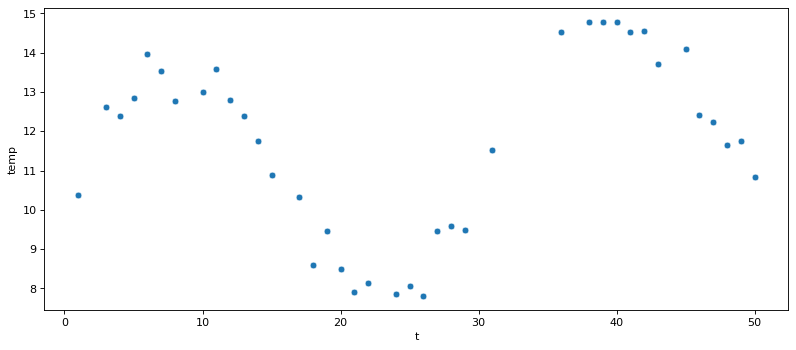

In [4]:
sns.scatterplot(df['t'], df['temp'])

In [5]:
# code adapted from tutorial 5

class Kernel:
    """Base class for kernels"""

    def __add__(self, kernel2):
        return SumKernel([self, kernel2])

    def __mul__(self, kernel2):
        return ProductKernel([self, kernel2])


class SumKernel:
    """Kernel to enable summation of kernels"""

    def __init__(self, kernels: List[Kernel]) -> None:
        self.kernels = kernels

    def __call__(self, X: np.ndarray, X2: np.ndarray = None) -> np.ndarray:
        return np.sum([k(X, X2) for k in self.kernels], axis=0)


class ProductKernel:
    """Kernel to enable product of kernels"""

    def __init__(self, kernels: List[Kernel]) -> None:
        self.kernels = kernels

    def __call__(self, X: np.ndarray, X2: np.ndarray = None) -> np.ndarray:
        return np.prod([k(X, X2) for k in self.kernels], axis=0)


class RBF(Kernel):
    def __init__(
        self, sigma_f: np.float64 = 1.0, lengthscale: np.float64 = 1.0
    ) -> None:
        self.sigma_f = sigma_f
        self.lengthscale = lengthscale

    def __call__(self, X: np.ndarray, X2: np.ndarray = None) -> np.ndarray:
        """
        Calculate a kernel matrix using the RBF kernel

        Args:
        - X: matrix with shape n1 x 1
        - X2: matrix with shape n2 x 1 or None (default), in which case X2=X

        Returns: n1 x n2 kernel matrix
        """

        if X2 is None:
            X2 = X

        # we make use of broadcasting to compute the pairwise difference
        # between each element of X and X2
        diff = (X[:, None, 0] - X2[None, :, 0]) ** 2
        K = self.sigma_f ** 2 * np.exp(-diff / (2 * self.lengthscale ** 2))
        return K


class PeriodicKernel(Kernel):
    def __init__(
        self,
        sigma_f: np.float64 = 1.0,
        lengthscale: np.float64 = 1.0,
        period: np.float64 = 1.0,
    ) -> None:
        self.sigma_f = sigma_f
        self.lengthscale = lengthscale
        self.period = period

    def __call__(self, X: np.ndarray, X2: np.ndarray = None) -> np.ndarray:
        """
        Calculate a kernel matrix using the periodic kernel function

        Args:
        - X: matrix with shape n1 x 1
        - X2: matrix with shape n2 x 1 or None (default), in which case X2=X

        Returns: n1 x n2 kernel matrix
        """

        if X2 is None:
            X2 = X

        # we make use of broadcasting to compute the pairwise difference
        # between each element of X and X2
        diff = np.abs(X[:, None, 0] - X2[None, :, 0])
        K = -2 * np.sin(np.pi * diff / self.period) ** 2
        K = self.sigma_f ** 2 * np.exp(K / self.lengthscale ** 2)
        return K

11.646003688161505


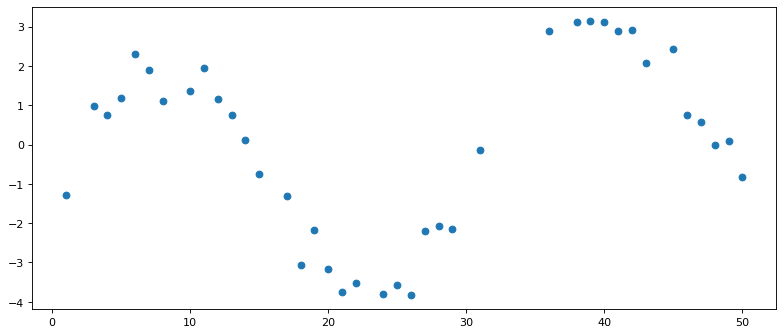

In [6]:
# format the data into matrices of the appropriate sizes
X = df["t"].values[:, None]
y = df["temp"].values[:, None]
mean_y = np.mean(y)
print(mean_y)
y -= mean_y

plt.scatter(X, y)

In [7]:
def fit_gp_posterior(
    X: np.ndarray, y: np.ndarray, X_star: np.ndarray, kernel: Kernel, sigma_n: float
) -> Tuple[np.ndarray]:
    """Returns the mean and variance of the GP posterior
    for data (X,y) and kernel function k_fn at test points X*
    sigma_n is the noise std
    """
    Kff = kernel(X)  # K(X,X)
    Kffs = kernel(X, X_star)  # K(X,X*)
    Kfsfs = kernel(X_star)  # K(X*,X*)

    # calculate posterior
    sigma_n_sq = sigma_n ** 2
    f_mean = Kffs.T @ np.linalg.solve(Kff + sigma_n_sq * np.eye(Kff.shape[0]), y)
    f_cov = Kfsfs - Kffs.T @ np.linalg.solve(
        Kff + sigma_n_sq * np.eye(Kff.shape[0]), Kffs
    )

    return f_mean, f_cov


def log_marg_likelihood(
    X: np.ndarray, y: np.ndarray, kernel: Kernel, sigma_n: float
) -> float:
    Kff = kernel(X)  # K(X,X)
    A = Kff + sigma_n ** 2 * np.eye(Kff.shape[0])
    lml = -0.5 * (
        y.T @ np.linalg.solve(A, y)
        + np.log(np.linalg.det(A) + 1e-9)
        + X.shape[0] * np.log(2 * np.pi)
    )
    return lml[0, 0]

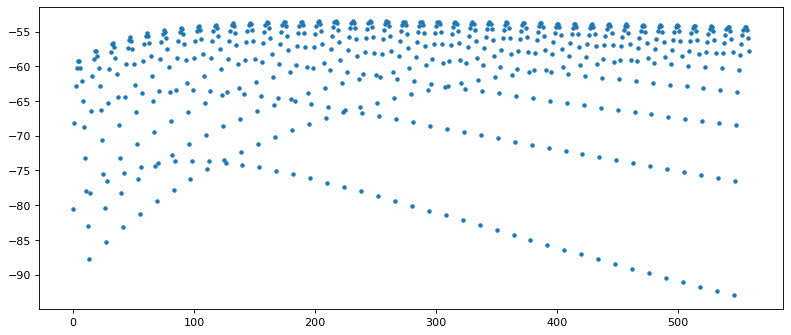

In [8]:
#RBF KERNEL
SIGMA_N = 1
#maybe u should go up to 8
sigmas = np.arange(1., 5., 0.1)
wavelengths = np.arange(1., 15.,1)
all_lml = []


for s in sigmas:
    for l in wavelengths:
        ker = RBF(sigma_f=s, lengthscale=l)
        lml = log_marg_likelihood(X, y, ker, SIGMA_N)
        all_lml.append((s, l, lml))

all_lml = pd.DataFrame(np.array(all_lml), columns=['s', 'l', 'lml'])

plt.plot(all_lml['lml'], '.')


In [9]:
best_s_RBF = all_lml[all_lml['lml'] ==np.max(all_lml['lml'])].values[0][0]
best_l_RBF = all_lml[all_lml['lml'] ==np.max(all_lml['lml'])].values[0][1]

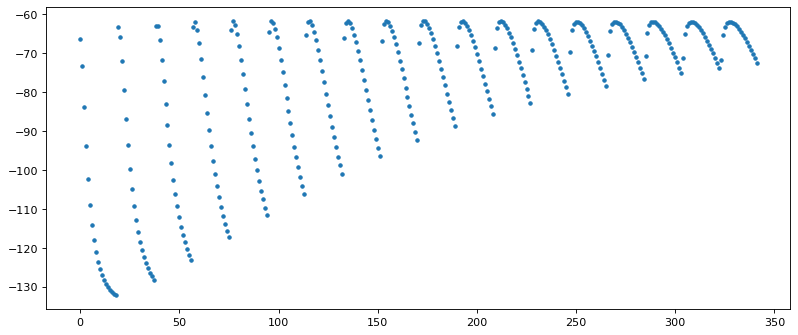

In [10]:
#PERIODIC KERNEL
SIGMA_N = 1
sigma_ns = np.arange(0.5, 1, 0.05)
sigmas = np.arange(1., 10., 0.5)
wavelengths = np.arange(1., 20.,1)
all_lml = []


for s in sigmas:
    for l in wavelengths:
        ker = PeriodicKernel(sigma_f=s, lengthscale=l, period=30)
        lml = log_marg_likelihood(X, y, ker, SIGMA_N)
        all_lml.append((s, l, lml))

all_lml = pd.DataFrame(np.array(all_lml), columns=['s', 'l', 'lml'])

plt.plot(all_lml['lml'], '.')


In [11]:
best_s_PERIODIC = all_lml[all_lml['lml'] ==np.max(all_lml['lml'])].values[0][0]
best_l_PERIODIC = all_lml[all_lml['lml'] ==np.max(all_lml['lml'])].values[0][1]

/Users/lysi2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in true_divide
/Users/lysi2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide
/Users/lysi2/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


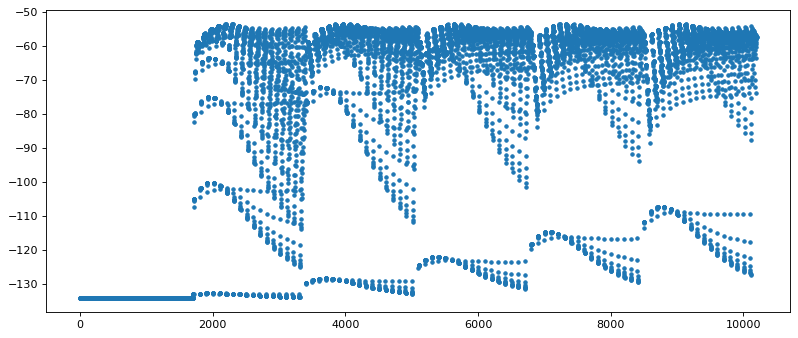

In [12]:
#MIXED KERNEL
SIGMA_N = 1
sigmas1 = np.arange(0., 3., 0.5)
wavelengths1 = np.arange(3., 20.,1)
sigmas2 = np.arange(0.1, 5., 0.5)
wavelengths2 = np.arange(0., 10.,1)
all_lml = []


for s in sigmas1:
    for l in wavelengths1:
        for s2 in sigmas2:
            for l2 in wavelengths2:
                ker = RBF(sigma_f=s, 
                    lengthscale=l) * PeriodicKernel(sigma_f=s2, 
                    lengthscale=l2, period=30)

                lml = log_marg_likelihood(X, y, ker, SIGMA_N)
                all_lml.append((s, l, s2, l2, lml))

all_lml = pd.DataFrame(np.array(all_lml), 
    columns=['s1', 'l1', 's2', 'l2' ,'lml'])

plt.plot(all_lml['lml'], '.')

In [13]:
best_s1_MIXED = all_lml[all_lml['lml'] ==np.max(all_lml['lml'])].values[0][0]
best_l1_MIXED = all_lml[all_lml['lml'] ==np.max(all_lml['lml'])].values[0][1]
best_s2_MIXED = all_lml[all_lml['lml'] ==np.max(all_lml['lml'])].values[0][2]
best_l2_MIXED = all_lml[all_lml['lml'] ==np.max(all_lml['lml'])].values[0][3]

In [14]:
print('RBF: ', best_s_RBF, best_l_RBF )
print('Periodic: ', best_s_PERIODIC, best_l_PERIODIC)
print('Mixed: ', best_s1_MIXED, best_l1_MIXED, best_s2_MIXED, best_l2_MIXED)

RBF:  2.6000000000000014 8.0
Periodic:  4.5 3.0
Mixed:  1.0 8.0 2.6 9.0


In [15]:
kernel_functions = [
    # RBF kernel
    RBF(sigma_f=best_s_RBF, lengthscale=best_l_RBF),
    # periodic kernel
    PeriodicKernel(sigma_f=best_s_PERIODIC, lengthscale=best_l_PERIODIC, period=30),
    # RBF x Periodic
    RBF(sigma_f=best_s1_MIXED, lengthscale=best_l1_MIXED)
    * PeriodicKernel(sigma_f=best_s2_MIXED, lengthscale=best_l2_MIXED, period=30),
]

In [16]:
gp_posteriors = [
    fit_gp_posterior(X, y, np.linspace(0, 50, 300)[:, None], kernel, SIGMA_N)
    for kernel in kernel_functions
]

In [17]:
all_lmls = [log_marg_likelihood(X, y, kernel, SIGMA_N) 
    for kernel in kernel_functions]
all_lmls

[-53.467340069131666, -61.684198461396974, -53.559533001347944]

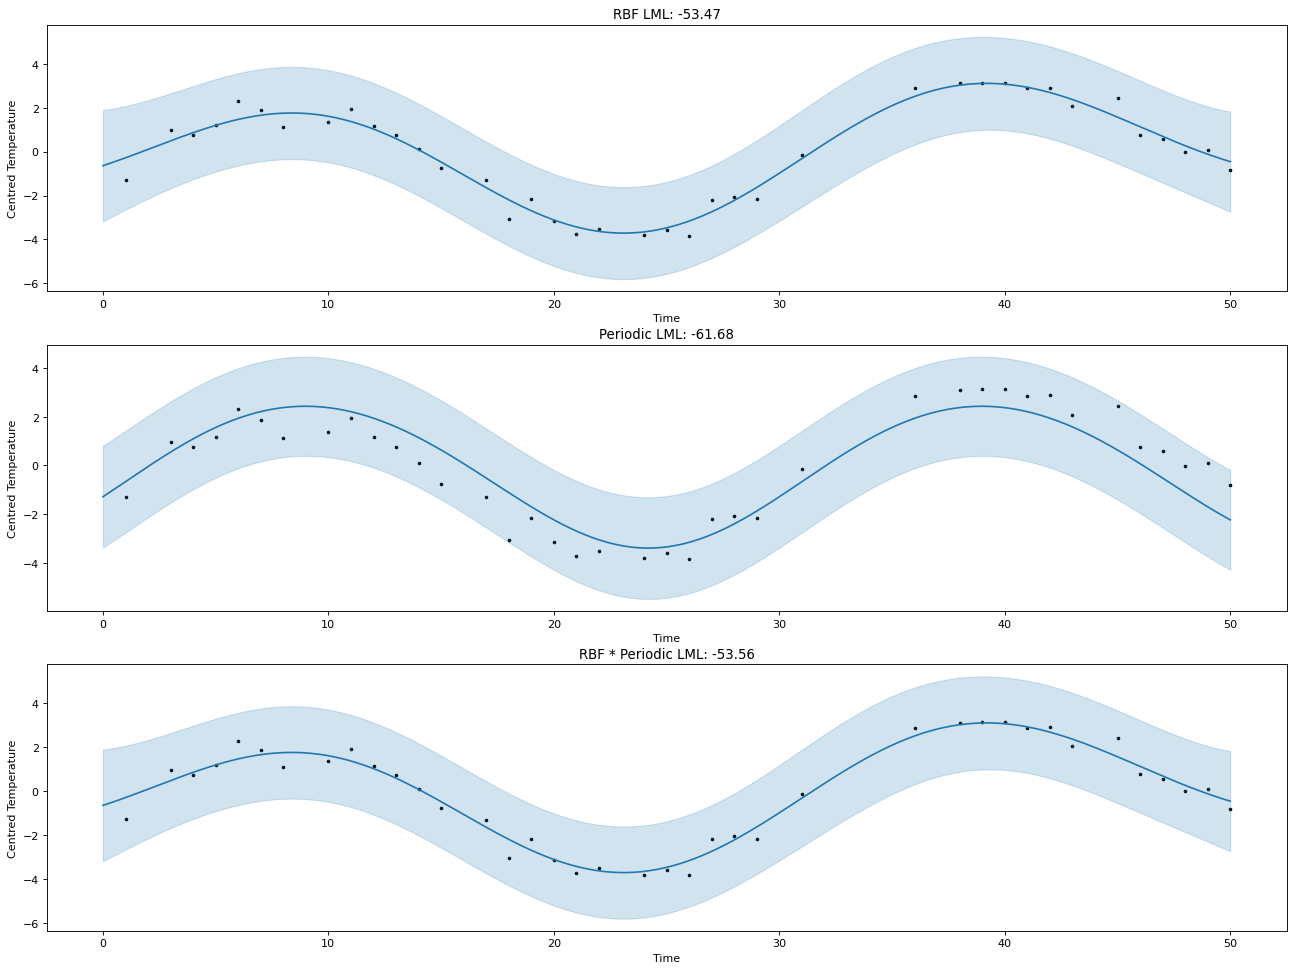

In [18]:
titles = ["RBF", "Periodic", "RBF * Periodic"]
x_plot = np.linspace(0, 50, 300)[:, None]
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
for i, (f_mean, f_cov) in enumerate(gp_posteriors):
    lml = all_lmls[i]
    f_var = np.diag(f_cov)[:, None]
    axs[i].plot(x_plot, f_mean, color="C0")
    axs[i].scatter(X, y, color="black", s=5)
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Centred Temperature")
    axs[i].set_title(titles[i] + f" LML: {np.round(lml, 2)}")

    # plot the 95% predictive distribution (f_var + likelihood_variance)
    axs[i].fill_between(
        x_plot[:, 0],
        (f_mean - 1.96 * np.sqrt(f_var + SIGMA_N ** 2))[:, 0],
        (f_mean + 1.96 * np.sqrt(f_var + SIGMA_N ** 2))[:, 0],
        color="C0",
        alpha=0.2,
    )
fig.savefig('plots/all_post.pdf')

In [19]:
Xs = np.array([[35]])
y_13 = 13 - mean_y
gp_posteriors_with_pred = [
    fit_gp_posterior(X, y, Xs, kernel, SIGMA_N) for kernel in kernel_functions
]

In [20]:
def compute_tail(mean, var):
    return 1 - norm(loc=mean, scale=np.sqrt(var)).cdf(y_13)[0][0]

In [21]:
probs = [compute_tail(preds[0], preds[1]) for preds 
            in gp_posteriors_with_pred]
probs


[0.9181506361000271, 0.7354600186766681, 0.913640674917684]

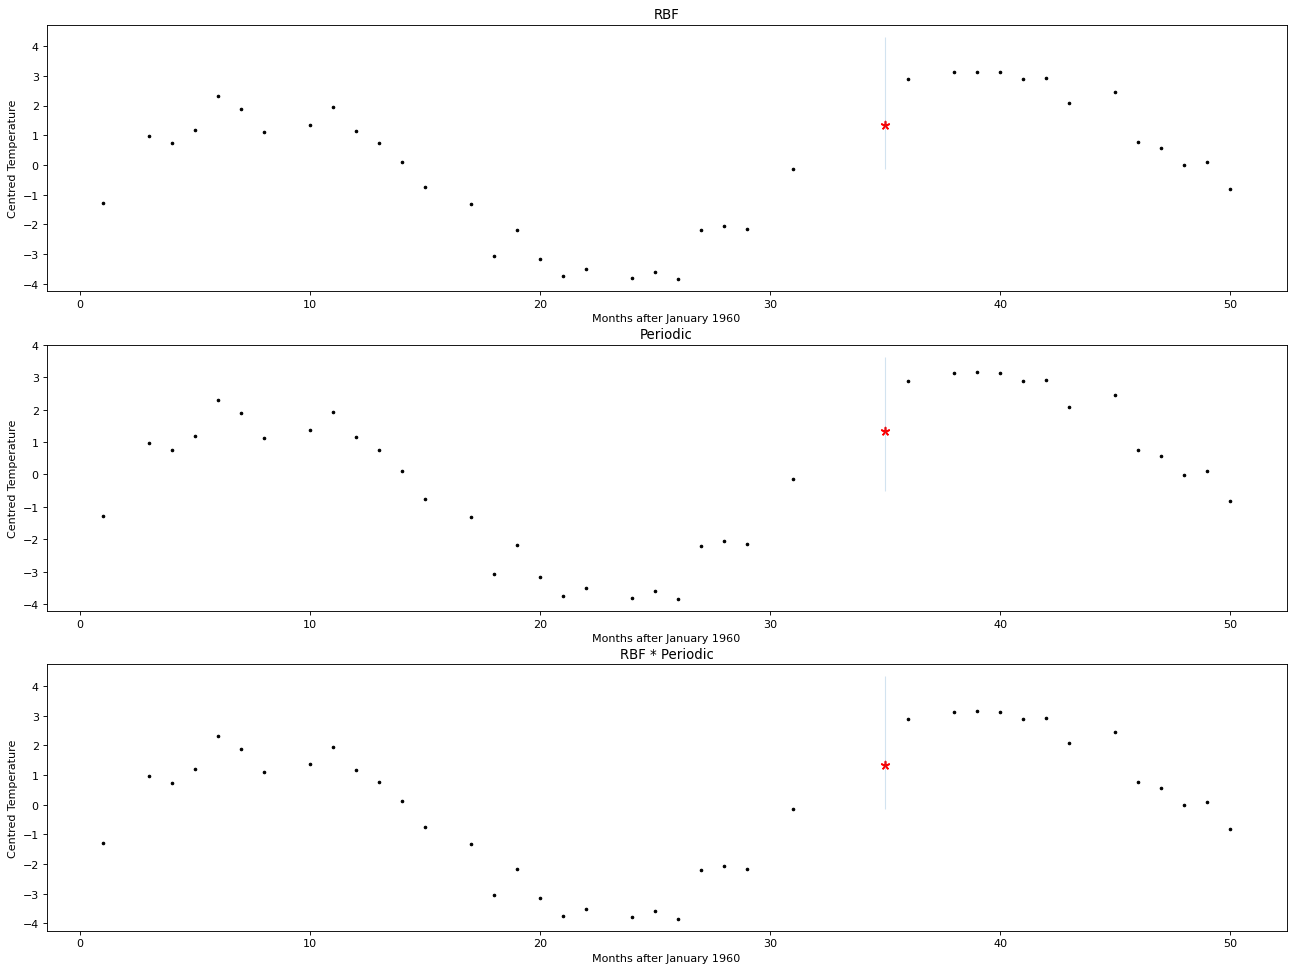

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
for i, (f_mean, f_cov) in enumerate(gp_posteriors_with_pred):
    lml = all_lmls[i]
    f_var = np.diag(f_cov)[:, None]
    # print(f_cov)
    axs[i].plot(Xs, f_mean, color="C0")
    axs[i].scatter(X, y, color="black", s=5)
    axs[i].scatter(35, y_13, color="red", s=50, marker=(5, 2))
    axs[i].set_xlabel("Months after January 1960")
    axs[i].set_ylabel("Centred Temperature")
    axs[i].set_title(titles[i])

    # plot the 95% predictive distribution (f_var + likelihood_variance)
    axs[i].fill_between(
        Xs[:, 0],
        (f_mean - 1.96 * np.sqrt(f_var + SIGMA_N ** 2))[:, 0],
        (f_mean + 1.96 * np.sqrt(f_var + SIGMA_N ** 2))[:, 0],
        color="C0",
        alpha=0.2,
    )
    # axs[i].set_xlim(578, 620)

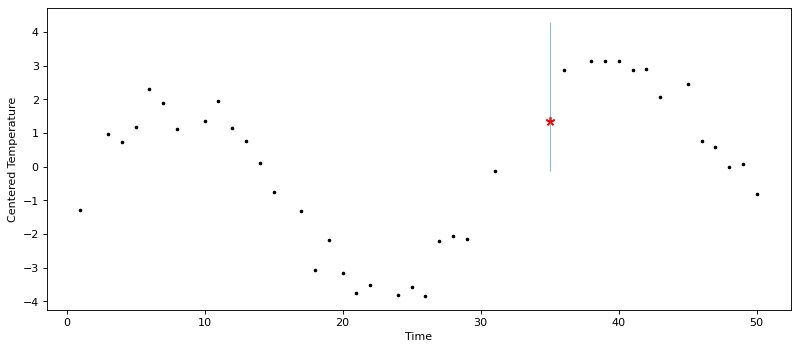

In [23]:
my_mean = gp_posteriors_with_pred[0][0]
my_cov = gp_posteriors_with_pred[0][1]
f_var = np.diag(my_cov)[:, None]
plt.plot(Xs, my_mean, color="C0")
plt.scatter(X, y, color="black", s=5)
plt.scatter(35, y_13, color="red", s=50, marker=(5, 2))
plt.fill_between(
        Xs[:, 0],
        (my_mean - 1.96 * np.sqrt(my_cov + SIGMA_N ** 2))[:, 0],
        (my_mean + 1.96 * np.sqrt(my_cov + SIGMA_N ** 2))[:, 0],
        color="C0",
        alpha=0.5,
    )
plt.xlabel('Time')
plt.ylabel('Centered Temperature')
plt.savefig('plots/y13.pdf')
plt.show()

### Part 2

/Users/lysi2/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


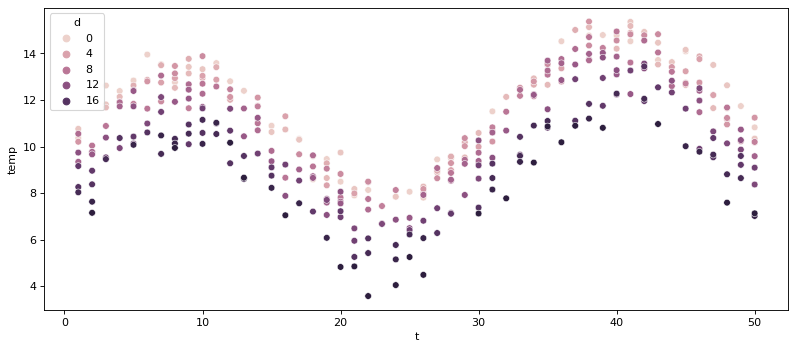

In [24]:
sns.scatterplot(d['t'], d['temp'], hue=d['d'])
plt.savefig('plots/tempsctr.pdf')
plt.show()

In [25]:
d = pd.read_csv('dataQ2.csv')
X = d[['t', 'd']].to_numpy()
y = d['temp'].to_numpy()[:, None]
mean_y = np.mean(y)
print(mean_y)
y -= mean_y
print(X.shape)
print(y.shape)

10.682292964569587
(400, 2)
(400, 1)


In [26]:
kern = ConstantKernel(constant_value=1) * sklearn.gaussian_process.kernels.RBF()

alphas = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 , 1.]
for a in alphas:
    gpr = GaussianProcessRegressor(kernel=kern, random_state=0, 
        alpha=a, normalize_y=False).fit(X,y)
    print('for a' , a, 'LML: ', gpr.log_marginal_likelihood_value_)


for a 0.1 LML:  -453.67340013419215
for a 0.2 LML:  -349.91931608633803
for a 0.25 LML:  -344.86563811989663
for a 0.3 LML:  -347.77820051358356
for a 0.4 LML:  -362.64427081528936
for a 0.5 LML:  -381.0779498778295
for a 0.6 LML:  -399.69966639671463
for a 0.7 LML:  -417.52251512450243
for a 0.8 LML:  -434.28131773333206
for a 0.9 LML:  -449.95481161013663
for a 1.0 LML:  -464.60560474838246


In [27]:
# kern = sklearn.gaussian_process.kernels.RBF()
kern = ConstantKernel(constant_value=1) * sklearn.gaussian_process.kernels.RBF()
gpr = GaussianProcessRegressor(kernel=kern, random_state=0,
 alpha=0.25, normalize_y=False).fit(X,y)
gpr.get_params

<bound method BaseEstimator.get_params of GaussianProcessRegressor(alpha=0.25, kernel=1**2 * RBF(length_scale=1),
                         random_state=0)>

In [28]:
y_pred, std = gpr.predict(X, return_std=True)

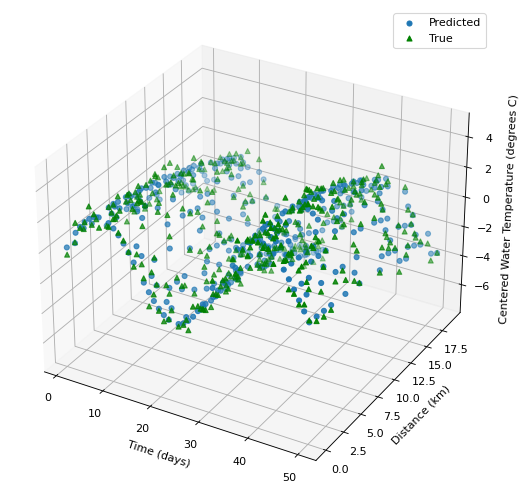

In [29]:
#code for 3d plot

# Fixing random state for reproducibility

fig = plt.figure(figsize= (18,8))
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
# for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
xs = X[:,0]
ys = X[:,1]
zs = y_pred
ax.scatter(xs, ys, zs, marker= 'o', label= 'Predicted')
ax.scatter(xs, ys, y, marker='^', color = 'green', label= 'True')
# ax.plot_surface(xs, ys, zs)


ax.set_xlabel('Time (days)')
ax.set_ylabel('Distance (km)')
ax.set_zlabel('Centered Water Temperature (degrees C)')
ax.legend()

plt.savefig('plots/3d.pdf')
plt.show()


In [30]:
def calc_post(model, d_val):
    X_star = np.array([55 - mean_y, d_val])[:, None].T
    y_star, std2 = model.predict(X_star, return_std=True)
    # print(y_star[0][0])
    return y_star[0][0], std2
    

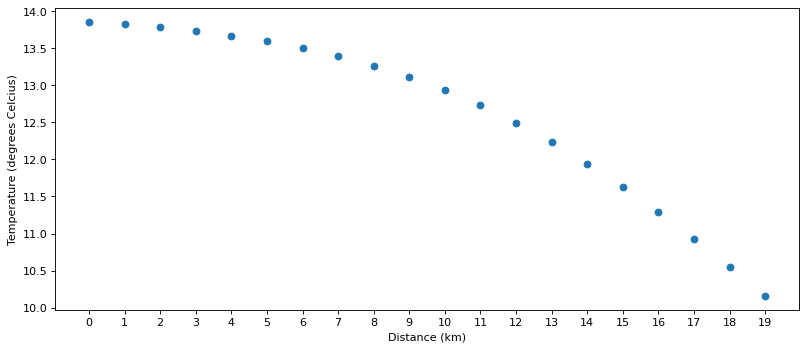

In [31]:
ds = np.arange(0,20,1)
y_all_stars =[]

for dval in ds:
    y_stars, stds = calc_post(gpr, dval)
    y_all_stars.append(y_stars)

plt.scatter(ds, np.array(y_all_stars) + mean_y)
plt.xticks(ds)
plt.xlabel('Distance (km)')
plt.ylabel('Temperature (degrees Celcius)')
plt.savefig('plots/last.pdf')
plt.show()